In [1]:
from scripts import pricing_ai
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
pd.set_option('display.max_rows',200)

#### **データ：価格の変動を持ったstockidデータ**

In [2]:
%%time
df = pricing_ai.get_data('sql/stock_cars.sql')

CPU times: user 1min 3s, sys: 32.5 s, total: 1min 36s
Wall time: 3min


#### **前処理：値段未設定を削除**

In [3]:
pricing_ai.print_shape(df)
df = df[df.price != 999999999]
pricing_ai.print_shape(df)

(59161303, 3)
(58740983, 3)


#### **データ：初回と成約**

In [4]:
first_pub = pricing_ai.get_preprocessing_data(sql_path='sql/first_pub.sql',col='min_date')
contract = pricing_ai.get_preprocessing_data(sql_path='sql/contract.sql',col='delete_date')

#### **データ：初回の日付と成約の日付作成**

In [5]:
start_day_dict = first_pub.set_index('stock_id')['min_date'].to_dict()
end_day_dict = contract.set_index('stock_id')['delete_date'].to_dict()

#### **前処理：初回と成約の日付を結合**

In [6]:
df['end_day']=df.stock_id.map(end_day_dict)
df['start_day']=df.stock_id.map(start_day_dict)

In [7]:
del start_day_dict, end_day_dict, first_pub, contract

In [8]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['stock_id', 'date'])

df['min_price'] = df.groupby('stock_id')['price'].transform('min')
df['max_price'] = df.groupby('stock_id')['price'].transform('max')

df['diff_price'] = df['max_price'] - df['min_price']

In [9]:
pricing_ai.print_shape(df)
df = df.dropna(subset=['start_day'])
pricing_ai.print_shape(df)

(58740983, 8)
(47388779, 8)


In [10]:
df_copy = df.copy()

#### 前処理：価格の下落がなかったもの

In [13]:
df['diff_per_stockid'] = df.groupby('stock_id').price.diff().fillna(0)

In [23]:
pricing_ai.print_shape(df)
df = df[df.diff_price == 0]
pricing_ai.print_shape(df)

(47388779, 9)
(20511433, 9)


In [25]:
price_diff_df = df.groupby(['stock_id', 'diff_per_stockid']).size().to_frame('count').reset_index()

In [ ]:
price_diff_df[price_diff_df.diff_per_stockid.ne(0)].groupby('stock_id')['count']\
                                            .sum()\
                                            .value_counts().head(10).plot.bar()
plt.xticks(rotation=45)
plt.show()

In [14]:
df.drop_duplicates('stock_id').max_price.mean().astype(int), df.drop_duplicates('stock_id').max_price.median().astype(int)

(1330468, 830000)

#### **前処理：stockidごとの物件詳細読み込み(価格下げ無し)**

In [23]:
stock_detail = pricing_ai.get_data('sql/stock_cars_options.sql')

In [35]:
stock_detail.shape

(9607267, 9)

In [179]:
stay_cars = stock_detail[stock_detail.stock_id.isin(df[df.diff_price == 0].stock_id.unique())]

In [26]:
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

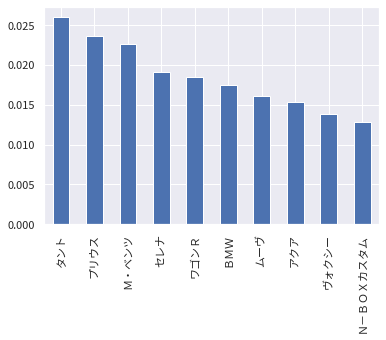

In [30]:
stay_cars.n_p_car_nm_n.value_counts(normalize=True).head(10).plot.bar()
plt.xticks(rotation=90)
plt.show()

#### **データ：stockidごとの物件詳細読み込み(価格下げ有り)**

In [22]:
pricing_ai.print_shape(df_copy)
df_copy = df_copy[df_copy.diff_price != 0]
pricing_ai.print_shape(df_copy)

(26877346, 8)
(26877346, 8)


In [193]:
stay_cars2 = stock_detail[stock_detail.stock_id.isin(df_copy.stock_id.unique())]

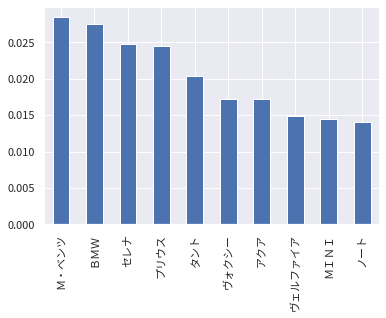

In [27]:
stay_cars2.n_p_car_nm_n.value_counts(normalize=True).head(10).plot.bar()
plt.xticks(rotation=90)
plt.show()

In [180]:
stay_price = stay_cars.n_p_car_nm_n.value_counts(normalize=True)
change_price = stay_cars2.n_p_car_nm_n.value_counts(normalize=True)

In [181]:
len(stay_price), len(change_price), len(set(stay_price.index) & set(change_price.index))

(1887, 1728, 1548)

In [182]:
only_in_stay_price = pd.DataFrame(set(stay_cars.n_p_car_nm_n) - set(stay_cars2.n_p_car_nm_n), columns=['car_name'])
only_in_change_price = pd.DataFrame(set(stay_cars2.n_p_car_nm_n) - set(stay_cars.n_p_car_nm_n), columns=['car_name'])

In [269]:
only_in_stay_price.shape, only_in_change_price.shape

((339, 1), (180, 1))

In [267]:
stay_cars2[stay_cars2.n_p_car_nm_n.isin(only_in_change_price.car_name)].head()

,stock_id,goo_car_id,n_p_country_nm_n,n_p_brand_nm_n,n_p_car_nm_n,n_p_grade_nm_n,syear,e_distance,price
35447,0507246A20201012J001,941020101300507246001,ドイツ,メルセデス・ベンツ,Ａクラスセダン,Ａクラスセダン ４ＭＡＴＩＣ,2019,6000,3598000
62391,0505174A20210319J002,941021032000505174002,アメリカ,テスラ,モデル３,ロングレンジ ＡＷＤ,2020,4000,6081000
68235,9510173A30210212W001,700951017330210212001,ドイツ,ＢＭＷアルピナ,アルピナ ＸＤ４,オールラッド,2020,12000,11680000
74490,0208255A20210121Q003,965021012200208255003,フランス,シトロエン,シトロエン ＤＳ３クロスバック,ソーシック,2020,2765,2639000
106000,0510328A30210522W001,700051032830210522001,日本,ダイハツ,グランマックストラック,ＧＬ スマートアシスト ＬＥＤヘッドライト キーレス,2020,17,1705000


In [268]:
stay_cars[stay_cars.n_p_car_nm_n.isin(only_in_stay_price.car_name)].head()

,stock_id,goo_car_id,n_p_country_nm_n,n_p_brand_nm_n,n_p_car_nm_n,n_p_grade_nm_n,syear,e_distance,price
36238,0402838A20200605Q001,976020060600402838001,フランス,ルノー,キャプチャー,インテンス,2018,6415,1820000
60133,1157656A20200718Q002,965020071901157656002,フランス,シトロエン,シトロエン Ｃ３ エアクロス,シャイン 登録済み未使用車 アップルカープレイ,2020,20,2099000
75453,9510160A20210629Q001,965021063009510160001,イギリス,ランドローバー,ランドローバー ディフェンダー,１１０ＳＥ,2020,15600,8499000
75573,0202629A30211113W001,700020262930211113001,イギリス,ジャガー,ジャガー Ｉペイス,ＳＥ,2020,9000,7999000
132449,0570670A20210429Q001,965021043000570670001,ドイツ,アウディ,アウディ ＲＳ３,ベースグレード,2020,800,7499000


In [183]:
print(stay_cars[stay_cars.price.astype(int) != 999999999].shape[0]/stay_cars.shape[0])
stay_cars = stay_cars[stay_cars.price.astype(int) != 999999999] 

0.9891298929723494


In [188]:
stay_cars.price.sort_values(ascending=False).head()

8960000    9999000
9306557    9999000
1457166    9999000
1730011    9999000
342090     9999000
Name: price, dtype: object

<AxesSubplot:ylabel='Frequency'>

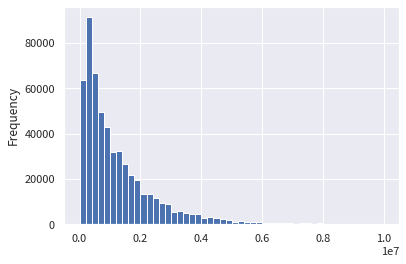

In [186]:
stay_cars[stay_cars.price.astype(int) <= 9999000].price.astype(int).plot.hist(bins=50)

In [194]:
print(stay_cars2[stay_cars2.price.astype(int) != 999999999].shape[0]/stay_cars2.shape[0])
stay_cars2 = stay_cars2[stay_cars2.price.astype(int) != 999999999] 

0.9967542775769298


In [198]:
print(stay_cars2[stay_cars2.price.astype(int) != 999999000].shape[0]/stay_cars2.shape[0])
stay_cars2 = stay_cars2[stay_cars2.price.astype(int) != 999999000] 

0.9999958225895559


In [200]:
stay_cars2.price.sort_values(ascending=False).head()

6878569    99990000
8997322    99990000
3432483     9999000
3067846     9999000
8244579     9999000
Name: price, dtype: object

<AxesSubplot:ylabel='Frequency'>

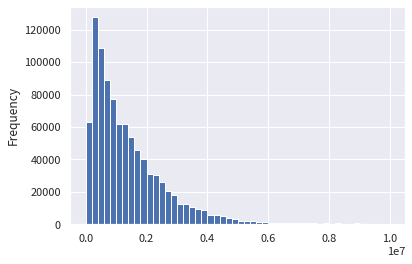

In [201]:
stay_cars2[stay_cars2.price.astype(int) <= 9999000].price.astype(int).plot.hist(bins=50)

In [ ]:
axes.twinx

In [298]:
stay_cars.stock_id.nunique()

506471

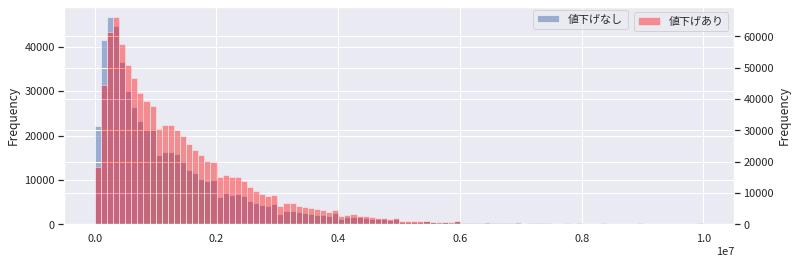

In [299]:
fig, axes = plt.subplots(1, 1 ,figsize=(12, 4) )
axes0 = axes.twinx()
stay_cars[stay_cars.price.astype(int) <= 1e7].price.astype(int).plot.hist(bins=100, ax=axes, alpha=0.5, label='値下げなし',legend=True)
axes.legend(loc=(0.8, 0.9))
stay_cars2[stay_cars2.price.astype(int) <= 1e7].price.astype(int).plot.hist(bins=100, ax=axes0, color='red', alpha=0.4, label='値下げあり',legend=True)
axes.legend(loc=(0.7, 0.9))


In [41]:
car_exit_per = pd.concat([stay_price.sort_index(), change_price.sort_index()], axis=1)

In [43]:
car_exit_per = car_exit_per.dropna()

In [45]:
car_exit_per.columns = ['stay', 'change']

In [103]:
car_exit_per['diif_per'] = car_exit_per['change']- car_exit_per['stay']

In [104]:
car_exit_per = car_exit_per.sort_values(by='diif_per',ascending=False)

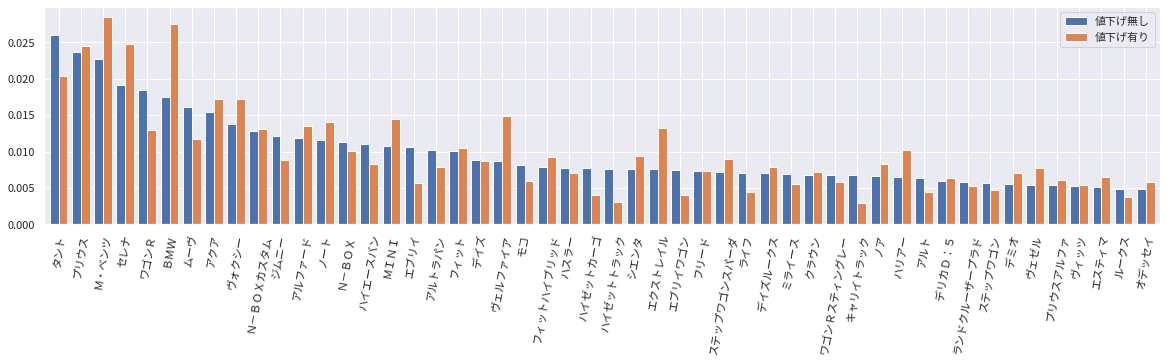

In [85]:
car_exit_per[['stay', 'change']].sort_values(by='stay', ascending=False).rename(columns={'stay':'値下げ無し','change':'値下げ有り'}).head(50).plot.bar(figsize=(20,4), width=0.8, stacked=False)
plt.xticks(rotation=80)
plt.show()

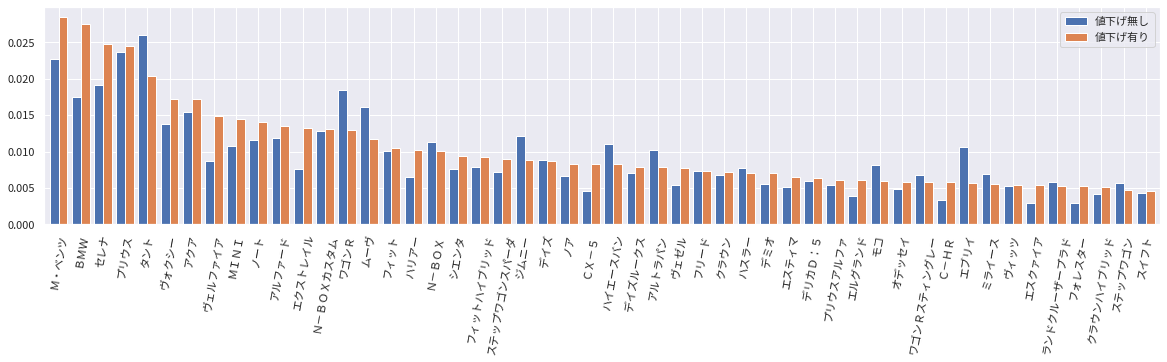

In [86]:
car_exit_per[['stay', 'change']].sort_values(by='change', ascending=False).rename(columns={'stay':'値下げ無し','change':'値下げ有り'}).head(50).plot.bar(figsize=(20,4), width=0.8, stacked=False)
plt.xticks(rotation=80)
plt.show()

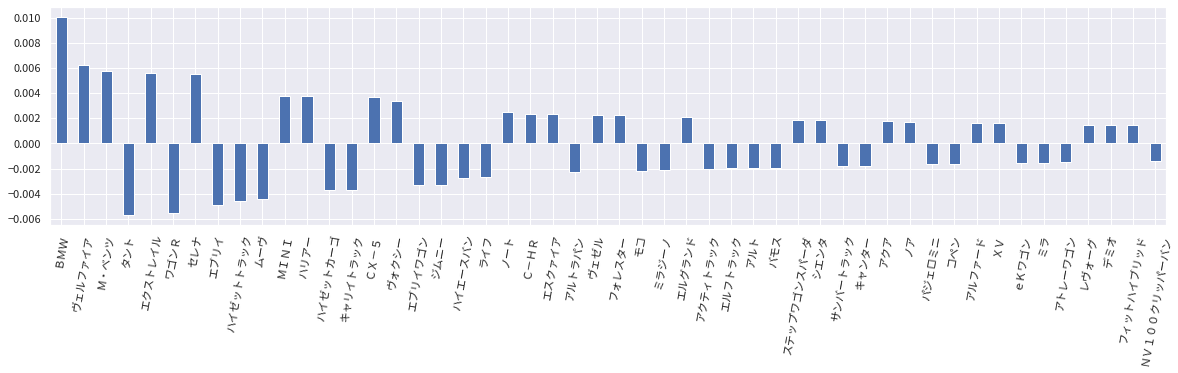

In [105]:
plt.figure(figsize=(20,4))
car_exit_per['diif_per'][car_exit_per.diif_per.abs().sort_values(ascending=False).index].head(50).plot.bar()
plt.xticks(rotation=80)
plt.show()

/tmp/ipykernel_72840/2077947206.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.drop_duplicates(subset=['stock_id'])[(df.diff_price==0) & (df.max_price<=1e7)].max_price.plot.hist(bins=50)


<AxesSubplot:ylabel='Frequency'>

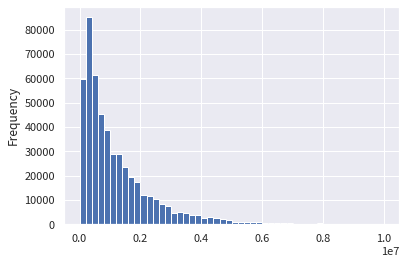

In [118]:
df.drop_duplicates(subset=['stock_id'])[(df.diff_price==0) & (df.max_price<=1e7)].max_price.plot.hist(bins=50)

/tmp/ipykernel_72840/4287585121.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.drop_duplicates(subset=['stock_id'])[(df.diff_price!=0) & (df.max_price<=1e7)].max_price.plot.hist(bins=50)


<AxesSubplot:ylabel='Frequency'>

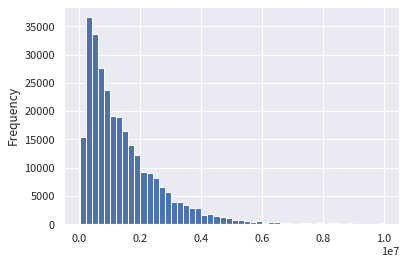

In [117]:
df.drop_duplicates(subset=['stock_id'])[(df.diff_price!=0) & (df.max_price<=1e7)].max_price.plot.hist(bins=50)

#### 可視化：初回掲載から成約までで価格の下落があったもの

<AxesSubplot:ylabel='Frequency'>

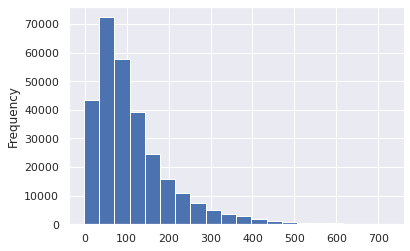

In [13]:
df_copy = df_copy[df_copy.diff_price != 0].drop_duplicates(subset=['stock_id'])
df_copy['keisai_day'] = df_copy['end_day']-df_copy['start_day']
df_copy['keisai_day'] = df_copy.keisai_day.astype('timedelta64[D]').astype(int)
df_copy['keisai_day'].plot.hist(bins=20)

In [14]:
df_copy.keisai_day.median(), df_copy.keisai_day.mean()

(87.0, 114.11965797195619)

In [31]:
df_copy

NameError: name 'df_copy' is not defined

In [270]:
stayANDchange_carnames = set(stay_price.index) & set(change_price.index)

In [275]:
len(stayANDchange_carnames)

1548

In [277]:
df['car_name'] = df['stock_id'].map(stock_detail.set_index('stock_id')['n_p_car_nm_n'].to_dict())

In [280]:
stayANDchange_df = df[df.car_name.isin(stayANDchange_carnames)]

In [283]:
stayANDchange_df.shape[0]/df.shape[0]

0.9986396779710235

In [285]:
stayANDchange_df

,date,stock_id,price,end_day,start_day,min_price,max_price,diff_price,car_name
21905771,2020-03-21,0100012A20200321Q001,1890000,2021-08-05,2020-03-21,1730000,1890000,160000,ヴェゼル
36527216,2020-03-22,0100012A20200321Q001,1890000,2021-08-05,2020-03-21,1730000,1890000,160000,ヴェゼル
27632509,2020-03-23,0100012A20200321Q001,1890000,2021-08-05,2020-03-21,1730000,1890000,160000,ヴェゼル
11011871,2020-03-24,0100012A20200321Q001,1890000,2021-08-05,2020-03-21,1730000,1890000,160000,ヴェゼル
37591003,2020-03-25,0100012A20200321Q001,1890000,2021-08-05,2020-03-21,1730000,1890000,160000,ヴェゼル
...,...,...,...,...,...,...,...,...,...
56422526,2021-07-25,9950045A30210706W001,280000,2021-07-30,2021-07-06,280000,280000,0,サンバートラック
56583253,2021-07-26,9950045A30210706W001,280000,2021-07-30,2021-07-06,280000,280000,0,サンバートラック
56562166,2021-07-27,9950045A30210706W001,280000,2021-07-30,2021-07-06,280000,280000,0,サンバートラック
56242036,2021-07-28,9950045A30210706W001,280000,2021-07-30,2021-07-06,280000,280000,0,サンバートラック


In [284]:
stayANDchange_df.shape[0]

47324315

In [294]:
stayANDchange_df.loc[:, 'diff_days'] = stayANDchange_df['end_day']-stayANDchange_df['start_day']
stayANDchange_df.loc[:, 'diff_days'] = stayANDchange_df['diff_days'].astype('timedelta64[D]')

/tmp/ipykernel_72840/1210447265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stayANDchange_df.loc[:, 'diff_days'] = stayANDchange_df['end_day']-stayANDchange_df['start_day']
/tmp/ipykernel_72840/1210447265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stayANDchange_df.loc[:, 'diff_days'] = stayANDchange_df['diff_days'].astype('timedelta64[D]')


In [296]:
stayANDchange_df[stayANDchange_df.diff_price.ne(0)].drop_duplicates(subset=['stock_id'])

,date,stock_id,price,end_day,start_day,min_price,max_price,diff_price,car_name,diff_days
21905771,2020-03-21,0100012A20200321Q001,1890000,2021-08-05,2020-03-21,1730000,1890000,160000,ヴェゼル,502.0
50769395,2020-03-21,0100012A20200321Q004,680000,2020-06-14,2020-03-21,590000,680000,90000,Ｎ－ＯＮＥ,85.0
1288998,2020-04-04,0100012A20200404Q001,990000,2021-08-05,2020-04-04,850000,990000,140000,プリウスアルファ,488.0
22900045,2020-06-13,0100012A20200613Q001,2850000,2020-11-17,2020-06-13,2780000,2850000,70000,エルグランド,157.0
11653276,2020-06-27,0100012A20200627Q001,920000,2021-08-05,2020-06-27,890000,920000,30000,ＮＴ１００クリッパートラック,404.0
...,...,...,...,...,...,...,...,...,...,...
28075009,2021-03-26,9940003A30210326W001,1399000,2021-05-05,2021-03-26,1359000,1399000,40000,ソリオバンディット,40.0
1029152,2021-06-13,9940003A30210613W003,899000,2021-08-22,2021-06-13,799000,899000,100000,パッソ,70.0
31764101,2021-07-07,9940003A30210707W001,999000,2021-09-28,2021-07-07,899000,999000,100000,アルトターボＲＳ,83.0
31130477,2021-08-14,9940003A30210814W001,3299000,2021-12-14,2021-08-14,3139000,3299000,160000,ハイエースバン,122.0
